In [15]:
import torch as t
import torchvision.transforms as tr
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import json
import os

In [73]:
if t.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = t.device(device)
device

device(type='cuda', index=0)

In [74]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F

class VanillaNet(nn.Module):
    def __init__(self, n_c=1, n_f=32, leak=0.05):
        super(VanillaNet, self).__init__()
        self.f = nn.Sequential(
            nn.Conv2d(n_c, n_f, 3, 1, 1),
            nn.LeakyReLU(leak),
            nn.Conv2d(n_f, n_f * 2, 4, 2, 1),
            nn.LeakyReLU(leak),
            nn.Conv2d(n_f*2, n_f*4, 4, 2, 1),
            nn.LeakyReLU(leak),
            nn.Conv2d(n_f*4, n_f*8, 4, 2, 1),
            nn.LeakyReLU(leak),
            nn.Conv2d(n_f*8, 1, 4, 1, 0))

    def forward(self, x):
        return self.f(x).squeeze()

In [75]:
net_bank = VanillaNet()
net_bank.to(device)

VanillaNet(
  (f): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.05)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.05)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.05)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.05)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)

In [76]:
import torch.optim as optim
lr = 1e-3
opt = optim.Adam(net_bank.parameters(), lr)

In [77]:
transform = tr.Compose([tr.Resize(32),
                        tr.CenterCrop(32),
                        tr.ToTensor(),
                        tr.Normalize(tuple(0.5*t.ones(1)), tuple(0.5*t.ones(1)))])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [78]:
for x in trainset:
  q = t.stack([x[0]]).to(device)

In [79]:
# sample batch from given array of images
def sample_image_set(image_set):
    rand_inds = t.randperm(image_set.shape[0])[0:100]
    return image_set[rand_inds], rand_inds

# sample positive images from dataset distribution q (add noise to ensure min sd is at least langevin noise sd)
def sample_q():
    x_q = sample_image_set(q)[0]
    return x_q + 1.5e-2 * t.randn_like(x_q)

def sample_s_t(L,update_s_t_0=True):
    # get initial mcmc states for langevin updates ("persistent", "data", "uniform", or "gaussian")
    x_s_t_0, s_t_0_inds = sample_q() , None
    x_s_t = t.autograd.Variable(x_s_t_0.clone(), requires_grad=True)
    r_s_t = t.zeros(1).to(device)  # variable r_s_t (Section 3.2) to record average gradient magnitude
    for ell in range(L):
        f_prime = t.autograd.grad(net_bank(x_s_t).sum(), [x_s_t])[0]
        x_s_t.data += - f_prime + 7.5e-3 * t.randn_like(x_s_t)
        r_s_t += f_prime.view(f_prime.shape[0], -1).norm(dim=1).mean()
    return x_s_t.detach(), r_s_t.squeeze() / L

device(type='cuda', index=0)

In [80]:
d_s_t_record = t.zeros(10000).to(device)  # energy difference between positive and negative samples
r_s_t_record = t.zeros(10000).to(device)

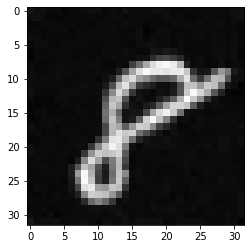

tensor(0.0037, device='cuda:0', grad_fn=<SubBackward0>)


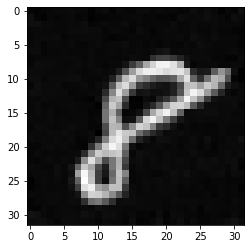

tensor(0.0027, device='cuda:0', grad_fn=<SubBackward0>)


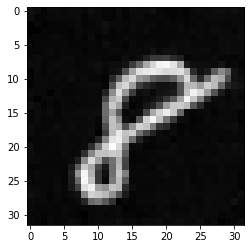

tensor(0.0001, device='cuda:0', grad_fn=<SubBackward0>)


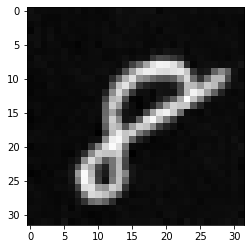

tensor(0.0023, device='cuda:0', grad_fn=<SubBackward0>)


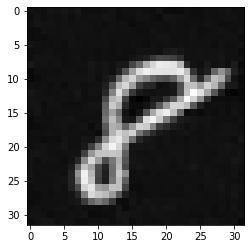

tensor(0.0018, device='cuda:0', grad_fn=<SubBackward0>)


In [93]:
for i in range(10):
    # obtain positive and negative samples
    x_q = sample_q()
    x_s_t, r_s_t = sample_s_t(L=500)
    img_np = x_s_t.detach().cpu().numpy()
    plt.imshow(img_np.reshape(32,32) , cmap='gray')
    plt.show()

    # calculate ML computational loss d_s_t (Section 3) for data and shortrun samples
    d_s_t = net_bank(x_q).mean() - net_bank(x_s_t).mean()

    print(d_s_t)
    if 7.5e-3 > 0:
        # scale loss with the langevin implementation
        d_s_t *= 2 / (7.5e-3 ** 2)
    # stochastic gradient ML update for model weights
    opt.zero_grad()
    d_s_t.backward()
    opt.step()

    # record diagnostics
    d_s_t_record[i] = d_s_t.detach().data
    r_s_t_record[i] = r_s_t
